# Dog Breed Identification (Part I): Data Exploration

This notebook was created to explore the dataset provided by the [Dog Breed Identification Kaggle competition](https://www.kaggle.com/c/dog-breed-identification). After this is accomplished, I will move onto another notebook, this time meant for performing the classification ("identification") task; i.e., given an image of a dog, what is its breed? I plan on using a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) architecture of some kind, but I'd like to build it from scratch rather than use a pre-trained network or a pre-defined network architecture.

I'm also interested in applying [GANs](https://arxiv.org/abs/1406.2661) to the data, in order to generate new images of dogs, or interpolate between different breeds of dogs, but I image that will take some heavy pre-processing, and may require more data than is available. 

One barrier to the GAN experiments is the noisiness of the data: many of the images show the _dogs at different scales or resolutions_, and there is plenty of _image clutter_ (including other dogs (!), humans (!), and items in the foreground). Perhaps by running [object localization](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/object_localization_and_detection.html) on the images (i.e., crop them by finding bounding boxes around the doggos, requiring another neural network trained for this task), we could create a dataset better suited to learning a generative model.

## Preliminary info

The dataset contains some 120 dog breeds. All images are taken from the [ImageNet dataset](https://www.kaggle.com/c/imagenet-object-detection-challenge); i.e., this data is a strict subset of ImageNet. All images depict good dogs (superimposed on various backgrounds / part of various middlegrounds)!

The Kaggle competition is evaluated on the [multiclass log loss](https://www.kaggle.com/wiki/MultiClassLogLoss), so we will eventually optimize our neural network models for this criterion.

__Note__: If you want to run this notebook yourself, you must join the Dog Breed Identification Kaggle competition (linked above), and download / unzip the data to the `data` directory.

## Imports & miscellany

In [1]:
import os
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import display, Image
from IPython.core.display import HTML

%matplotlib inline

## Inspect some doggos

Let's take a look at some sample images from the training data.

In [2]:
# Creating paths to training / test data.
train_path = os.path.join('..', 'data', 'train')
test_path = os.path.join('..', 'data', 'test')

# Creating paths to pre-processed training / validation / test data.
processed_train_path = os.path.join('..', 'data', 'processed_train')
processed_valid_path = os.path.join('..', 'data', 'processed_valid')
processed_test_path = os.path.join('..', 'data', 'processed_test')

# Make sure these directories exist.
for directory in [ processed_train_path, processed_valid_path, processed_test_path ]:
    if not os.path.isdir(directory):
        os.makedirs(directory)

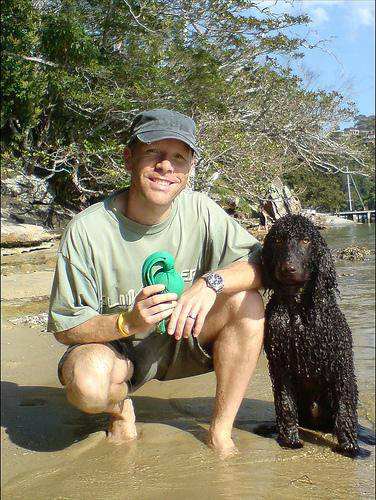

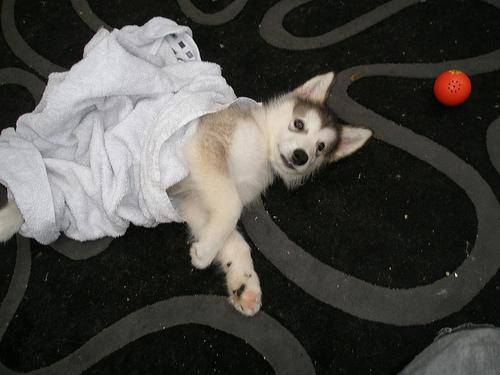

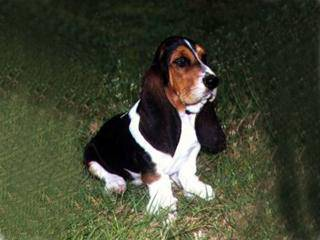

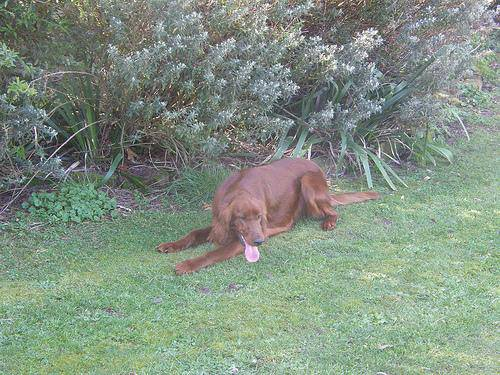

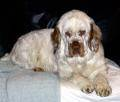

In [3]:
n_train = len(os.listdir(train_path))
sample_idxs = np.random.choice(n_train, 5, replace=False)

for idx in sample_idxs:
    # Choose a random file from the training data directory.
    filename = os.listdir(train_path)[idx]
    
    # Display the image contained in the chosen file.
    image = Image(os.path.join(train_path, filename))
    display(image)

Those are some handsome doggos! One thing to notice: The images come in many shapes and sizes. This can be problematic for training neural networks, but _convolutional neural networks_ actually handle this quite naturally due to a property they exhibit known as [translation invariance](https://stats.stackexchange.com/questions/208936/what-is-translation-invariance-in-computer-vision-and-convolutional-neural-netwo); basically, the same feature has equal importance at different points in the input space. However, due to computational considerations (GPUs are more efficient when input data is uniformly sized), we will standardize the input below.

Note: If you keep sampling (by running this bit of code), you'll notice that there are some __weird__ examples (perhaps corresponding to outliers, in some statistical sense). For example, I've notice images including __dogs and humans__ or __multiple breeds of dog__ in a single picture. This should be confusing to our neural network model; however, we hope that there are much fewer weird examples than there are typical ones! Even so, these examples may help to __regularize__ the network; that is, allow for better performance on unseen data. We also hope that examples like these help make our neural network models robust to background noise (i.e., irrelevant information).

## Tell me more about these doggos!

Let's get a feel for the dataset we're working with. We're looking for simple statistics at this point: How much (training, test) data do we have? What is the typical size of an image, and how does this vary? How well-represented is each dog breed in the datset?

In [4]:
# Get the number of training, testing data.
n_train, n_test = len(os.listdir(train_path)), len(os.listdir(test_path))

# Print them out!
print('No. training data:', n_train)
print('No. test data:', n_test)

No. training data: 10222
No. test data: 10357


In [5]:
# Calculate the average, minimum, and maximum width 
# and height of images in the training data.
widths, heights = [], []
width_min, width_max = np.inf, -np.inf
height_min, height_max = np.inf, -np.inf

for filename in os.listdir(train_path):
    image = PIL.Image.open(os.path.join(train_path, filename))
    
    # Append image dimensions to list.
    widths.append(image.size[0])  # width
    heights.append(image.size[1])  # height

In [6]:
# Print out stats for viewing pleasure. 
print('Training data average (width, height): ', (np.mean(widths), np.mean(heights)))
print('Training data (minimum width, maximum width): ', (np.min(widths), np.max(widths)))
print('Training data (minimum height, maximum height): ', (np.min(heights), np.max(heights)))
print('Training data (STD of widths, STD of heights): ', (np.std(widths), np.std(heights)))

Training data average (width, height):  (443.33153981608297, 386.74721189591077)
Training data (minimum width, maximum width):  (97, 3264)
Training data (minimum height, maximum height):  (102, 2562)
Training data (STD of widths, STD of heights):  (152.41266408441547, 130.06196422027517)


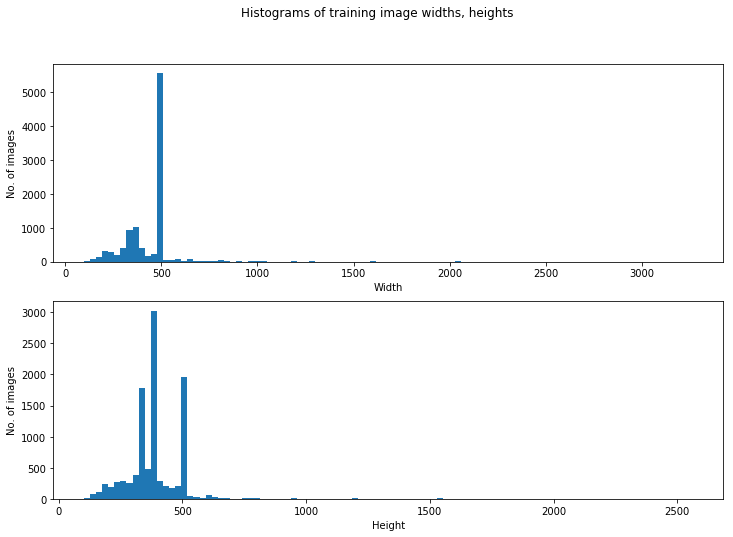

In [7]:
# Plot histograms of heights and widths.
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Histograms of training image widths, heights')

ax1.hist(widths, bins=100); ax1.set_xlabel('Width'); ax1.set_ylabel('No. of images')
ax2.hist(heights, bins=100); ax2.set_xlabel('Height'); ax2.set_ylabel('No. of images')

plt.show()

The data varies __dramatically__ in size, but _most are concentrated around the average width and height_.

## How are the doggo breeds distributed?

Let's look at the distribution of labels for the training data. We'll start by loading up the labels, and then taking a look at some simple statistics. 

In [8]:
# Load up the training data labels using pandas (for .csv files, it's quite fast).
train_labels_path = os.path.join('..', 'data', 'labels.csv')
train_labels = pd.read_csv(train_labels_path)

# Show the first 10 lines of the DataFrame containing fields "id" and "breed".
train_labels.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [9]:
# Use the built-in DataFrame function `describe` function to see a short summary of the data.
train_labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,42ce977acb6a65196535182062d248d4,scottish_deerhound
freq,1,126


This is a nice feature, but we want more detail. Let's try creating a histogram of the dog breeds.

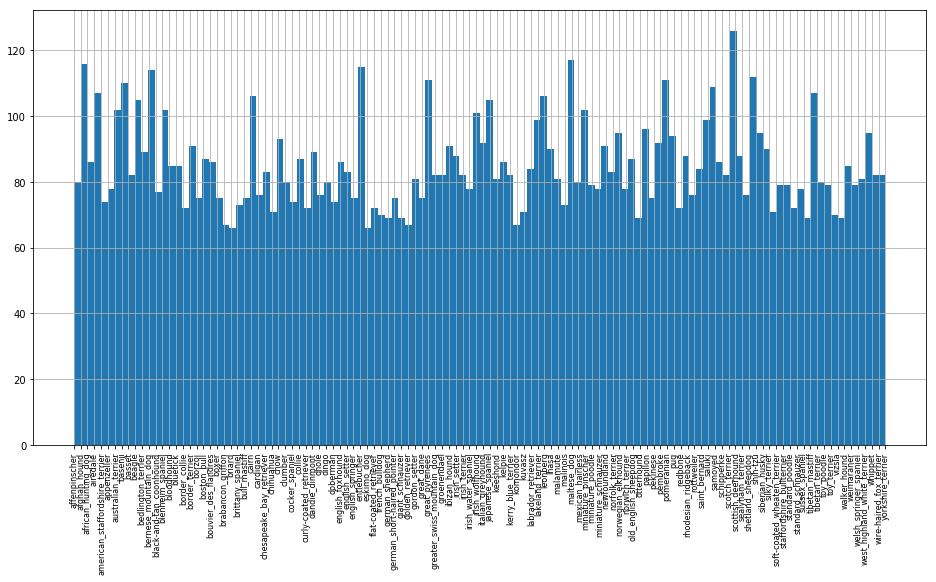

In [10]:
# Use the built-in DataFram function `hist` to plot a histogram of the dog breeds.
hist = train_labels['breed'].hist(figsize=(16, 8), bins=120, xrot=90, xlabelsize=8)
plt.show()

If you squint your eyes at the x-axis, you will be able to make out the dog breeds listed there, and match them up with their frequency in the training data. It's an informative (and nice-looking!) plot: We can see that no dog breed occurs fewer than 60 times or more than 130 times in the training data, and we might expect better (worse) test accuracies on the breeds for which there are more (less) data.

## Doggo pre-processing

To make our lives easier prior to neural network training, we shall pre-process our data into a format amenable to neural network libraries. Namely, we'll store the data as `numpy.ndarrays`, a super-efficient data structure designed for _quickly manipulating and computing with n-dimensional arrays_.

1. We'll pre-process all the data into equally-sized images, _amenable to efficient GPU operation_ during neural network training.
2. We'll split the training data into _training, validation partitions_ to use for network [_hyper-parameter tuning_](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)).

We begin by defining a function to read a single image into a `numpy.ndarray` object. This will read an `.jpg` image from disk, and resize it into a fixed width and height. We choose a __default image size of (256, 256)__, since it seems reasonable to somewhat downsample the images without losing too much information.

One could employ Fourier analysis on the images to confirm that we aren't losing too much high-frequency information in the image data, but due to lack of time, we will let this go empirically unjustified. Of course, we might expect to lose more information on the larger images, but on the whole, most images will only be mildly altered.

In [11]:
def read_img(ID, train=True, size=(256, 256)):
    """
    Read and resize a single image.
    
    - Arguments:
        ID (str): ID of image to be read.
        train (bool): Whether this is a training or test image.
        size (tuple(int)): The new size of the image.
    
    - Returns:
        Image as numpy.ndarray.
    """
    # Get the image from disk using pillow.
    if train:
        image = PIL.Image.open(os.path.join(train_path, '%s.jpg' % ID))
    else:
        image = PIL.Image.open(os.path.join(test_path, '%s.jpg' % ID))
    
    # Cast the Pillow image to a numpy.ndarray and return it.
    image = np.array(image.resize(size))
    return image

Now, we will run through all the training and test data, creating `numpy.ndarray`s as we go, to be used during neural network training and evaluation. 

In [12]:
# Specify training / validation split percentages.
train_split = 0.8  # 80% of the labeled data is used for network training.

__Note__: You'll likely need ~16Gb of memory in order to run the code block below.

In [13]:
# Create a 4D array of shape (N, W, H, D) containing all the training data.
X_train = np.array([ read_img(ID.split('.')[0]) for ID in sorted(os.listdir(train_path)) ])

# Split the labeled data into training, validation partitions.
X_train, X_valid = X_train[:int(0.8 * len(X_train))], X_train[int(0.8 * len(X_train)):]

print('Shape of training data (N, W, H, D):', X_train.shape)
print('Shape of validation data (N, W, H, D):', X_valid.shape)

Shape of training data (N, W, H, D): (8177, 256, 256, 3)
Shape of validation data (N, W, H, D): (2045, 256, 256, 3)


In [14]:
# Create a mapping from dog breeds (image categories) to unique integer labels.
breeds = sorted(train_labels['breed'].unique())
class_map = { breed : idx for idx, breed in enumerate(breeds) }
inverse_class_map = { idx : breed for breed, idx in class_map.items()}

In [15]:
# Create a 1D array of shape (N,) contained all the training labels.
y_train = np.array([ class_map[train_labels[train_labels['id'] == \
                        ID.split('.')[0]]['breed'].tolist()[0]] for \
                                ID in sorted(os.listdir(train_path)) ])

# Split the labeled data into training, validation partitions.
y_train, y_valid = y_train[:int(0.8 * len(y_train))], y_train[int(0.8 * len(y_train)):]

print('Shape of training labels (N, K):', y_train.shape)
print('Shape of validation labels (N, K):', y_valid.shape)

# Save out the pre-processed training, validation data to disk.
for idx, (features, target) in enumerate(zip(X_train, y_train)):
    np.save(os.path.join(processed_train_path, 'train%d.npy' % idx), (features, target))

for idx, (features, target) in enumerate(zip(X_valid, y_valid)):
    np.save(os.path.join(processed_valid_path, 'valid%d.npy' % idx), (features, target))

del X_train, y_train, X_valid, y_valid

Shape of training labels (N, K): (8177,)
Shape of validation labels (N, K): (2045,)


In [16]:
# Create a 4D array of shape (N, W, H, D) containing all the training data.
X_test = np.array([ read_img(ID.split('.')[0], train=False) for ID in sorted(os.listdir(test_path)) ])

print('Shape of test data (N, W, H, D):', X_test.shape)

# Save out the pre-processed training data to disk.
for idx, datum in enumerate(X_test):
    np.save(os.path.join(processed_test_path, 'test%d.npy' % idx), datum)

del X_test

Shape of test data (N, W, H, D): (10357, 256, 256, 3)


## Looking at pre-processed doggos

To wrap up this notebook, why don't we take a look at some examples from the (preprocessed) validation data, along with their labels? 

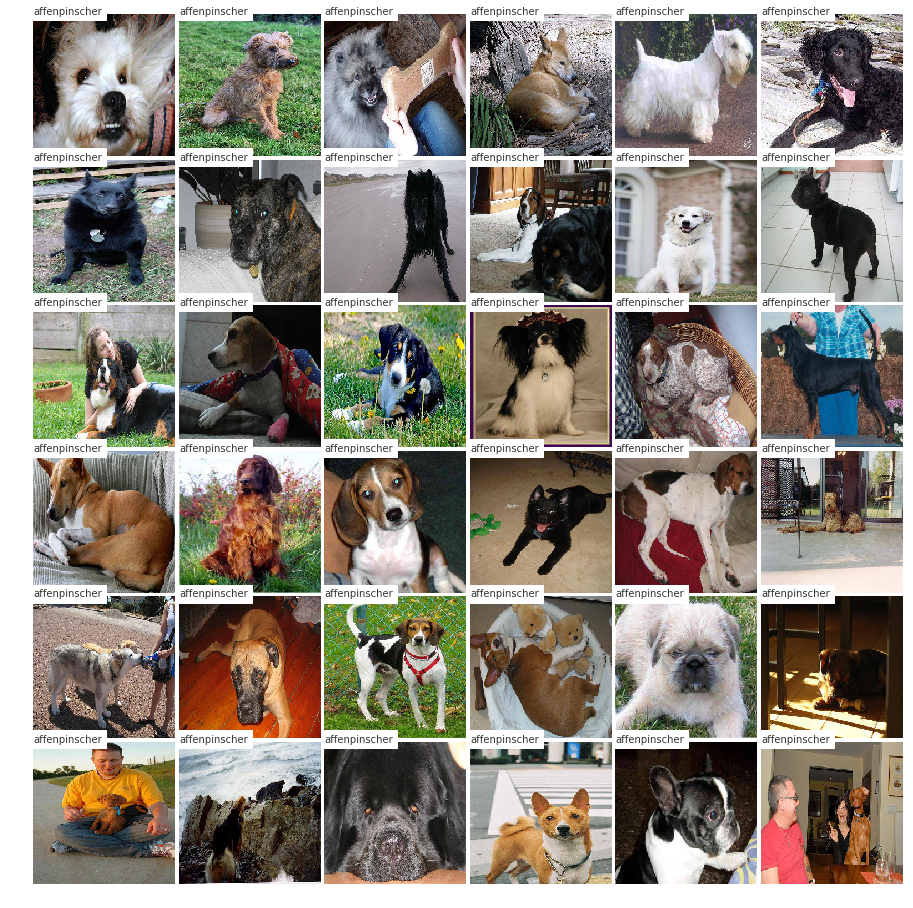

In [17]:
# Number of images to display in a __square__ grid.
n_im = 36
n_im_sqrt = int(np.sqrt(n_im))

# Reload the validation images and labels.
valid = np.array([ np.load(os.path.join(processed_valid_path, 'valid%d.npy' % idx)) for idx in range(n_im) ])
X_valid = valid[:, 0]
y_valid = valid[:, 1]

# Take a sample of `n_im` images and corresponding labels from the validation data.
sample_idxs = np.random.choice(X_valid.shape[0], size=n_im, replace=False)
X = X_valid[sample_idxs]
y = y_valid[sample_idxs]

# Create an ImageGrid of the sampled validation images
# with their corresponding categorical labels.
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(n_im_sqrt, n_im_sqrt), axes_pad=0.05)
for idx in range(n_im):
    ax = grid[idx]
    ax.imshow(X[idx] / 255)
    ax.axis('off')
    
    int_label = np.argmax(y[idx])
    ax.text(0, 0, '%s' % inverse_class_map[int_label], color='k', backgroundcolor='w', alpha=0.8)

Aren't they beautiful?

Now, all images have size (256, 256), as mentioned above. You'll notice that some images seem lower-resolution than others; this is likely due to their original size being far from the chosen default image size. We might instead be interested in keeping the images' original [aspect ratio](https://en.wikipedia.org/wiki/Aspect_ratio_(image)), rescaling it, and taking fixed crops of the image (say, top left, top right, center, ...), which is typically used as a [__data_augmentation__](https://www.quora.com/What-does-the-term-data-Augmentation-mean-in-the-context-of-Machine-Learning) technique, which, again, helps to __regularize__ the neural network training process.